In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Link Prediction using similarity methods and random forest

In [2]:
Target = pd.read_csv('musae_ENGB_target.csv')
Edges = pd.read_csv('musae_ENGB_edges.csv')

In [3]:
#create network from edges set
edge = [list(i) for i in zip(Edges['from'], Edges['to'])]
G = nx.Graph()
G.add_edges_from(edge)

In [4]:
#converting true to 1, false to 0
Target[['mature','partner']] = (Target[['mature','partner']] == True).astype(int)
#add attributes to nodes
Target_dict = {}
for idx, row in Target.iterrows():
    Target_dict[row.new_id] = {'days': row.days, 'mature':row.mature, 'views':row.views, 'partner': row.partner}

nx.set_node_attributes(G, Target_dict)

In [68]:
training_df = pd.read_csv("sim_df.csv", index_col=0)
training_df.head()

,from,to,link
1026943,3405,6469,0
1063613,261,6284,0
688356,166,4456,0
133454,24,1773,0
4608,7106,3470,0


In [69]:
training_df['idx'] = training_df[['from','to']].values.tolist()
training_df.head()

,from,to,link,idx
1026943,3405,6469,0,"[3405, 6469]"
1063613,261,6284,0,"[261, 6284]"
688356,166,4456,0,"[166, 4456]"
133454,24,1773,0,"[24, 1773]"
4608,7106,3470,0,"[7106, 3470]"


In [73]:
training_df = training_df.set_index('idx')

In [74]:
future_connections = pd.DataFrame({"Future Connection":training_df['link']})

In [75]:
future_connections.head()

,Future Connection
idx,
"[3405, 6469]",0
"[261, 6284]",0
"[166, 4456]",0
"[24, 1773]",0
"[7106, 3470]",0


In [27]:
df = future_connections
df['pa'] = [i[2] for i in nx.preferential_attachment(G, df.index)]
df['cn'] = df.index.map(lambda person: len(list(nx.common_neighbors(G, person[0], person[1]))))
df['jc'] = [i[2] for i in nx.jaccard_coefficient(G, df.index)]
df['rai'] = [i[2] for i in nx.resource_allocation_index(G, df.index)]
df['aai'] = [i[2] for i in nx.adamic_adar_index(G, df.index)]

In [30]:
df.head()

,Future Connection,pa,cn,jc,rai,aai
idx,,,,,,
"[3405, 6469]",0,6,0,0.00000,0.000000,0.000000
"[261, 6284]",0,782,0,0.00000,0.000000,0.000000
"[166, 4456]",0,6336,0,0.00000,0.000000,0.000000
"[24, 1773]",0,87840,24,0.02934,1.082891,7.303528
"[7106, 3470]",0,80,0,0.00000,0.000000,0.000000


In [43]:
y = df['Future Connection']
X = df.drop(['Future Connection'], axis=1)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [47]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score

In [45]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=5)
rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=10)

In [52]:
from joblib import dump
dump(rfc,"rfc.joblib")

['rfc.joblib']

In [48]:
from sympy import rf


prob = rfc.predict_proba(X_test)
predictions = rfc.predict(X_test)

In [50]:
rfc.acc = accuracy_score(y_test, predictions)
rfc_roc = roc_auc_score(y_test, prob[:,1])

In [51]:
print(rfc_roc, rfc.acc)

0.7647906178378351 0.7134371583084607


# Visualization

In [59]:
adj_G = nx.to_numpy_matrix(G)
target_pairs = np.where(adj_G == 0)

In [60]:
target_pairs = [[target_pairs[0][i],target_pairs[1][i]] for i in range(len(target_pairs[0])) if target_pairs[0][i]!=target_pairs[1][i]]

In [89]:
from random import sample
X_vis = sample(target_pairs, 500000)

In [90]:
X_vis = pd.DataFrame(X_vis)

In [91]:
X_vis["idx"] = X_vis[[0,1]].values.tolist()
X_vis = X_vis.set_index("idx")
X_vis.head()

,0,1
idx,,
"[3356, 25]",3356,25
"[1283, 2659]",1283,2659
"[5464, 6475]",5464,6475
"[6032, 5630]",6032,5630
"[5920, 6680]",5920,6680


In [92]:
X_vis['pa'] = [i[2] for i in nx.preferential_attachment(G, X_vis.index)]
X_vis['cn'] = X_vis.index.map(lambda person: len(list(nx.common_neighbors(G, person[0], person[1]))))
X_vis['jc'] = [i[2] for i in nx.jaccard_coefficient(G, X_vis.index)]
X_vis['rai'] = [i[2] for i in nx.resource_allocation_index(G, X_vis.index)]
X_vis['aai'] = [i[2] for i in nx.adamic_adar_index(G, X_vis.index)]

In [93]:
rfc_pred = rfc.predict(X_vis[['pa','cn','jc','rai','aai']])

In [100]:
unique, counts = np.unique(rfc_pred, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 481983]
 [     1  18017]]


In [94]:
rfc_edge = []
for i in range(len(rfc_pred)):
    if rfc_pred[i] == 1:
        rfc_edge.append((X_vis[0][i],X_vis[1][i]))

In [96]:
G_rfc = G.__class__()
G_rfc.add_nodes_from(G)
G_rfc.add_edges_from(G.edges)
for e in G.edges():
    G_rfc[e[0]][e[1]]["color"] = "SlateBlue"

In [97]:
G_rfc.add_edges_from(rfc_edge)
for e in rfc_edge:
    G_rfc[e[0]][e[1]]["color"] = "Orange"

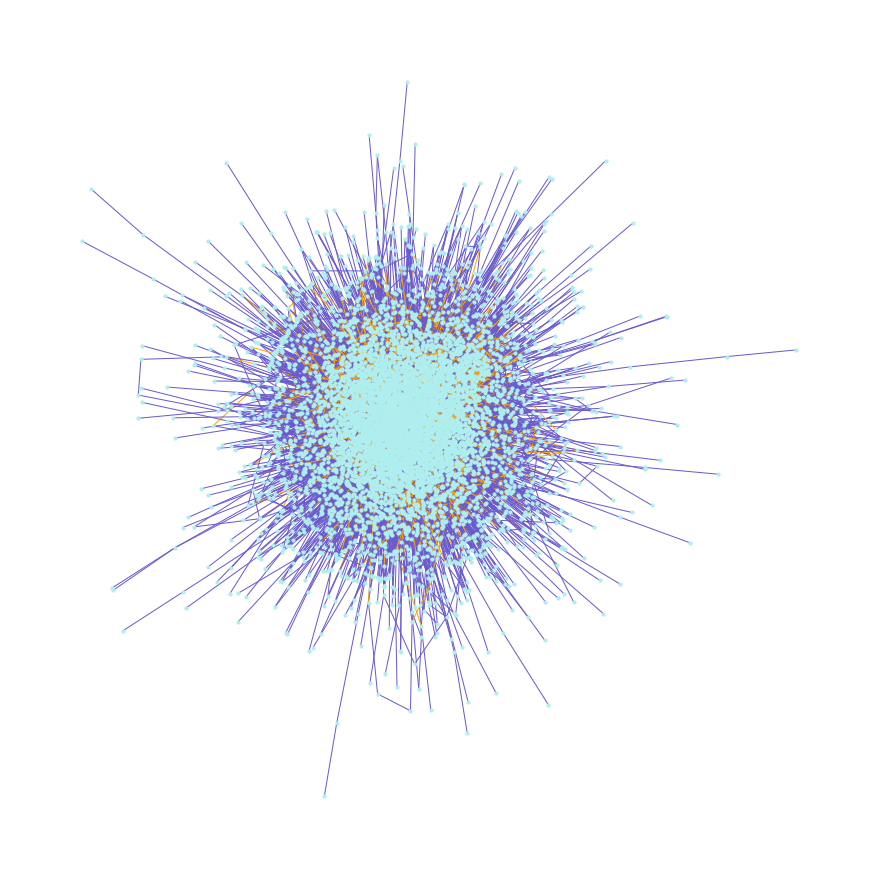

In [98]:
colors = [G_rfc[u][v]['color'] for u,v in G_rfc.edges()]
plt.figure(figsize=(12,12)) 
nx.draw(G_rfc,node_color="PaleTurquoise", node_size=10, edge_color=colors, with_labels=False)
plt.show()